### Install yfinance package

In [14]:
# pip install yfinance

### Initial basic libraries

In [15]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import numpy as np

### Libraries used for pulling data

In [16]:
import alpaca_trade_api as tradeapi
import csv
import json
from datetime import datetime, timezone

### Libraries used for visualization

In [17]:
import plotly.express as px
import hvplot.pandas
import matplotlib.pyplot as plt
import panel as pn
pn.extension('plotly')
from panel.interact import interact
import plotly.tools
import seaborn as sns

### Libraries used for data analysis

In [18]:
from MCForecastTools import MCSimulation

### New libraries used

In [19]:
# Yahoo finance for data pulling of S&P500 index
import yfinance as yf

# Warning filter that removes warning messages
import warnings
warnings.filterwarnings("ignore")

In [20]:
# Load .env variables
load_dotenv()

True

## Fetching Stock Data

In [21]:
# Set Alpaca API key and secret key
alpaca_key = os.getenv('ALPACA_API_KEY')
alpaca_priv_key = os.getenv('ALPACA_SECRET_KEY')

In [22]:
# Check data types to ensure key imports were successful
print(type(alpaca_key))
print(type(alpaca_priv_key))

<class 'str'>
<class 'str'>


In [23]:
# Create alpaca API object
api = tradeapi.REST(
    alpaca_key,
    alpaca_priv_key,
    api_version = 'v2')

In [24]:
# Create parameters to be used in data pulling
start = pd.Timestamp('2017-05-05', tz='America/New_York').isoformat()
end = pd.Timestamp('2022-05-05', tz='America/New_York').isoformat()
tickers = ['AAPL', 'MSFT', 'AMZN' , 'TSLA', 'GOOGL']
timeframe = '1Day'

In [25]:
# Pull data
stock_pulled_df = api.get_bars(
    tickers,
    timeframe,
    start = start,
    end = end
).df

In [26]:
# Pull S&P500 data
sp500 = yf.Ticker('^GSPC')
sp500 = sp500.history(period='5y', start_date=start, end_date=end)

In [27]:
# Reformat S&P500 dataframe to allign with stock dataframe
# Drop index column name
sp500.index.name = None

# Initialize drop list
sp500_drop_list = ['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits']

# Rename close column
sp500 = sp500.drop(sp500_drop_list, axis=1).rename(columns = {'Close' : 'close'})

# Save S&P500 data to csv
sp500.to_csv('Data_files/S&P500.csv')

In [28]:
# Create a list of columns needed to be removed
drop_list = ['open', 'vwap', 'high', 'low', 'volume', 'trade_count', 'symbol']

# Slice dataframe and drop columns
aapl = stock_pulled_df[stock_pulled_df['symbol']=='AAPL'].drop(drop_list, axis=1)
msft = stock_pulled_df[stock_pulled_df['symbol']=='MSFT'].drop(drop_list, axis=1)
amzn = stock_pulled_df[stock_pulled_df['symbol']=='AMZN'].drop(drop_list, axis=1)
tsla = stock_pulled_df[stock_pulled_df['symbol']=='TSLA'].drop(drop_list, axis=1)
googl = stock_pulled_df[stock_pulled_df['symbol']=='GOOGL'].drop(drop_list, axis=1)

# Concatenate sliced data into new dataframe
stock_df = pd.concat(
    [aapl, msft, amzn, tsla, googl],
    axis=1,
    keys=['AAPL', 'MSFT', 'AMZN', 'TSLA', 'GOOGL']
)

# Index dataframe by date
stock_df.index=stock_df.index.date

# Drop any Null values
stock_df.dropna()

AAPL    MSFT     AMZN    TSLA    GOOGL
             close   close    close   close    close
2017-05-05  148.96   69.00   934.15  308.35   950.28
2017-05-08  153.01   68.94   949.04  307.19   958.69
2017-05-09  153.99   69.04   952.82  321.26   956.71
2017-05-10  153.26   69.31   948.95  325.22   954.84
2017-05-11  153.95   68.46   947.62  323.10   955.89
...            ...     ...      ...     ...      ...
2022-04-29  157.65  277.52  2485.63  870.76  2282.19
2022-05-02  157.96  284.47  2490.00  902.94  2331.66
2022-05-03  159.48  281.78  2485.07  909.25  2346.68
2022-05-04  166.02  289.98  2518.57  952.62  2445.22
2022-05-05  156.77  277.35  2328.14  873.28  2330.11

[1260 rows x 5 columns]

## Fetching Crypto Data

In [29]:
# Defining URLs
btc_url = 'https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=usd&from=1493906401&to=1651759199'
eth_url = 'https://api.coingecko.com/api/v3/coins/ethereum/market_chart/range?vs_currency=usd&from=1493906401&to=1651759199'
ltc_url = 'https://api.coingecko.com/api/v3/coins/litecoin/market_chart/range?vs_currency=usd&from=1493906401&to=1651759199'
xrp_url = 'https://api.coingecko.com/api/v3/coins/ripple/market_chart/range?vs_currency=usd&from=1493906401&to=1651759199'
ada_url = 'https://api.coingecko.com/api/v3/coins/cardano/market_chart/range?vs_currency=usd&from=1493906401&to=1651759199'

In [30]:
# Perform GET request to pull data for cryptos
btc_request = requests.get(btc_url)
eth_request = requests.get(eth_url)
ltc_request = requests.get(ltc_url)
xrp_request = requests.get(xrp_url)
ada_request = requests.get(ada_url)

In [31]:
# Convert pulled data into json
btc_request = btc_request.json()
eth_request = eth_request.json()
ltc_request = ltc_request.json()
xrp_request = xrp_request.json()
ada_request = ada_request.json()

In [32]:
# Create and organize dataframes for cryptos
btc_df = pd.DataFrame(btc_request['prices'])
eth_df = pd.DataFrame(eth_request['prices'])
ltc_df = pd.DataFrame(ltc_request['prices'])
xrp_df = pd.DataFrame(xrp_request['prices'])
ada_df = pd.DataFrame(ada_request['prices'])

In [33]:
# Rename columns
btc_df.rename(columns = {0 : 'Date', 1 : 'close'}, inplace=True)
eth_df.rename(columns = {0 : 'Date', 1 : 'close'}, inplace=True)
ltc_df.rename(columns = {0 : 'Date', 1 : 'close'}, inplace=True)
xrp_df.rename(columns = {0 : 'Date', 1 : 'close'}, inplace=True)
ada_df.rename(columns = {0 : 'Date', 1 : 'close'}, inplace=True)

In [34]:
# Convert unix time format into traditonal date format
btc_df['date'] = pd.to_datetime(btc_df['Date'], unit='ms')
eth_df['date'] = pd.to_datetime(eth_df['Date'], unit='ms')
ltc_df['date'] = pd.to_datetime(ltc_df['Date'], unit='ms')
xrp_df['date'] = pd.to_datetime(xrp_df['Date'], unit='ms')
ada_df['date'] = pd.to_datetime(ada_df['Date'], unit='ms')

In [35]:
# Set new date format as index
btc_df.set_index('date', inplace=True)
eth_df.set_index('date', inplace=True)
ltc_df.set_index('date', inplace=True)
xrp_df.set_index('date', inplace=True)
ada_df.set_index('date', inplace=True)

In [36]:
# Drop unix column
btc_df.drop(['Date'], axis=1, inplace=True)
eth_df.drop(['Date'], axis=1, inplace=True)
ltc_df.drop(['Date'], axis=1, inplace=True)
xrp_df.drop(['Date'], axis=1, inplace=True)
ada_df.drop(['Date'], axis=1, inplace=True)

In [96]:
## Concatenate crypto dataframes
# Create a list of cypto tickers
crypto_df = pd.concat(
    [btc_df, eth_df, ltc_df, xrp_df, ada_df],
    axis=1,
    keys=['BTC', 'ETH', 'LTC',  'XRP', 'ADA']
)

crypto_tickers = crypto_df.droplevel(axis=1, level=[-1]).keys().tolist()

In [97]:
# Concatenate crypto and stock data
combined_investments = pd.concat(
    [crypto_df, stock_df],
    axis=1,
    keys=['Crypto Data', 'Stock Data']
)

# Save data to csv
combined_investments.to_csv('Data_files/combined_investments.csv')

## Profit after 5 years

In [98]:
# Initialize Dataframe structure
investment_data = {'Investment' : [None],
                  'Profit After 5 Years' : [None]}

# Initialize Dataframe
value_after_5_years = pd.DataFrame(investment_data).drop(0)

In [99]:
# Define Function that calculates profit then appends investment into a dataframe
def value_today_after_5_years(data, data2, investment_type, investment):
    investment_type=investment_type
    investment=investment
    data=(combined_investments[investment_type][investment].fillna(method='bfill', axis=0).iloc[0]).values[0]
    data2=(combined_investments[investment_type][investment].fillna(method='bfill', axis=0).iloc[-1]).values[0]
    profit=(4000/data) * data2 - 4000
    df_variable=pd.DataFrame({'Investment' : [investment],
                              'Profit After 5 Years' : [profit]})
    return value_after_5_years.append(df_variable, ignore_index=True)

In [100]:
# Run function for each investment
value_after_5_years = value_today_after_5_years(
    investment_type='Stock Data',
    investment='AAPL',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Stock Data',
    investment='MSFT',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Stock Data',
    investment='AMZN',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Stock Data',
    investment='TSLA',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Stock Data',
    investment='GOOGL',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Crypto Data',
    investment='BTC',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Crypto Data',
    investment='ETH',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Crypto Data',
    investment='LTC',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Crypto Data',
    investment='XRP',
    data=combined_investments,
    data2=combined_investments  
)

value_after_5_years = value_today_after_5_years(
    investment_type='Crypto Data',
    investment='ADA',
    data=combined_investments,
    data2=combined_investments  
)

In [42]:
# Change index to investments
value_after_5_years = value_after_5_years.set_index('Investment')

In [43]:
# Plot the profits after 5 years in bar graph
combined_value_after_5_years_bar = value_after_5_years.hvplot.bar(
    title='Profit of Each Investment After 5 Years',
    ylabel='Profit in USD',
    xlabel='Investment',
    color='green',
    yformatter='%.0f'
).opts(axiswise=True)

combined_value_after_5_years_bar

:Bars   [Investment]   (Profit After 5 Years)

In [44]:
# Plot the profits after 5 years in line graph
combined_value_after_5_years_line = value_after_5_years.hvplot.line(
    title='Profit of Each Investment After 5 Years',
    ylabel='Profit in USD',
    xlabel='Investment',
    color='green',
    yformatter='%.0f',
).opts(axiswise=True)

combined_value_after_5_years_line

:Curve   [Investment]   (Profit After 5 Years)

In [45]:
# Plot the profits of stocks after 5 years in bar graph
stock_value_after_5_years = value_after_5_years.drop(crypto_tickers)

stock_value_after_5_years_bar = stock_value_after_5_years.hvplot.bar(
    title='Profits of Stocks After 5 Years',
    ylabel='Profit Made After 5 Years (USD)',
    color='green',
    yformatter='%.0f'
).opts(axiswise=True)

stock_value_after_5_years_bar

:Bars   [Investment]   (Profit After 5 Years)

In [46]:
# Plot the profits of crypto after 5 years in bar graph
crypto_value_after_5_years_bar = value_after_5_years.iloc[5:10].hvplot.bar(
    yformatter='%.0f',
    title='Profits of Crypto After 5 Years',
    ylabel='Profit Made After 5 Years (USD)'
).opts(axiswise=True)

crypto_value_after_5_years_bar

:Bars   [Investment]   (Profit After 5 Years)

In [47]:
prices_start = (combined_investments.fillna(method='bfill', axis=0).iloc[0])
prices_latest = (combined_investments.fillna(method='bfill', axis=0).iloc[-1])

## Calculate daily and cumulative returns

In [48]:
# Calculate daily returns for stock
stock_daily_returns = stock_df.pct_change()

# Rename columns
stock_daily_returns.rename(columns = {'close' : 'Daily Return %'}, inplace=True)

In [49]:
# Calculate daily returns for stock
crypto_daily_returns = crypto_df.pct_change()

# Rename columns
crypto_daily_returns.rename(columns = {'close' : 'Daily Return %'}, inplace=True)

In [50]:
# Create merged dataframe for stock and crypto
daily_returns = pd.merge(
    crypto_daily_returns, 
    stock_daily_returns,
    left_index=True, 
    right_index=True)

# Save csv file
daily_returns.to_csv('Data_files/daily_returns.csv')

In [51]:
# Calculate cumulative daily returns
cumulative_returns = (1 + daily_returns).cumprod()
cumulative_returns.to_csv('Data_files/cumulative_returns.csv')

## Invesment Planning

In [52]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns, stocks
mc_even_dist = MCSimulation(
    portfolio_data = stock_df, 
    weights = [0.2, 0.2, 0.2, 0.2, 0.2], 
    num_simulation = 500, 
    num_trading_days = 252*5
)

In [53]:
# Printing the simulation input data
mc_even_dist.portfolio_data.head()

AAPL                MSFT                 AMZN               \
             close daily_return  close daily_return   close daily_return   
2017-05-05  148.96          NaN  69.00          NaN  934.15          NaN   
2017-05-08  153.01     0.027189  68.94    -0.000870  949.04     0.015940   
2017-05-09  153.99     0.006405  69.04     0.001451  952.82     0.003983   
2017-05-10  153.26    -0.004741  69.31     0.003911  948.95    -0.004062   
2017-05-11  153.95     0.004502  68.46    -0.012264  947.62    -0.001402   

              TSLA                GOOGL               
             close daily_return   close daily_return  
2017-05-05  308.35          NaN  950.28          NaN  
2017-05-08  307.19    -0.003762  958.69     0.008850  
2017-05-09  321.26     0.045802  956.71    -0.002065  
2017-05-10  325.22     0.012326  954.84    -0.001955  
2017-05-11  323.10    -0.006519  955.89     0.001100

In [54]:
# Run Monte-Carlo Simulation
mc_even_dist.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     1.003243  0.987903  0.995824  0.977655  0.989711  1.012949  1.008448   
2     0.986780  0.976986  1.024140  0.997481  0.995874  1.006291  1.021771   
3     0.988883  0.970496  1.013535  0.977957  0.982389  1.014387  1.025035   
4     1.006005  0.996909  1.011849  0.990550  0.973553  1.019981  1.028313   
...        ...       ...       ...       ...       ...       ...       ...   
1256  8.659944  3.412578  3.730153  6.669147  7.557409  4.883864  6.566192   
1257  8.732954  3.393821  3.746065  6.601247  7.609700  4.851234  6.596719   
1258  8.774178  3.431169  3.718225  6.598905  7.435925  4.910371  6.672440   
1259  8.822837  3.408307  3.699279  6.688022  7.403376  4.928145  6.582585   
1260  8.689733  3.464975  3.702537  6.643810  7.495934  5.006222  6.688968   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.998308  1.014728  1.000256  ...  1.004991  0.991651  1.005318   
2     0.997277  1.000163  1.010281  ...  1.010389  0.999361  1.019533   
3     1.011001  1.006180  1.017470  ...  1.029094  0.994144  1.039661   
4     1.006369  1.005835  1.023854  ...  1.021922  0.994406  1.038365   
...        ...       ...       ...  ...       ...       ...       ...   
1256  3.822104  4.763416  3.652720  ...  2.163854  8.209735  3.226762   
1257  3.891738  4.753024  3.634172  ...  2.206527  7.977567  3.231411   
1258  3.899152  4.743536  3.685828  ...  2.242845  7.911606  3.219307   
1259  3.937382  4.843004  3.650982  ...  2.269691  7.880898  3.240223   
1260  3.967195  4.810842  3.707136  ...  2.247647  7.883358  3.304248   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.002073  0.994043  1.003133  0.992391  0.995596  0.996650  1.006739  
2     1.003395  0.987698  1.001028  1.013940  0.985780  0.987854  1.021777  
3     0.978682  0.980811  0.993146  1.031120  0.981731  0.984914  1.016956  
4     0.975538  0.974827  0.991952  1.034135  0.987414  1.001355  1.007303  
...        ...       ...       ...       ...       ...       ...       ...  
1256  5.943785  3.373083  1.875246  5.508110  3.700266  5.280177  1.609469  
1257  6.059541  3.315675  1.874551  5.536554  3.713365  5.298981  1.601860  
1258  6.059438  3.353929  1.875159  5.630053  3.665250  5.202258  1.610375  
1259  6.061762  3.360093  1.877839  5.716913  3.661336  5.206332  1.610145  
1260  6.009829  3.357555  1.872102  5.656689  3.739616  5.177398  1.606031  

[1261 rows x 500 columns]

Text(0, 0.5, 'Return x')

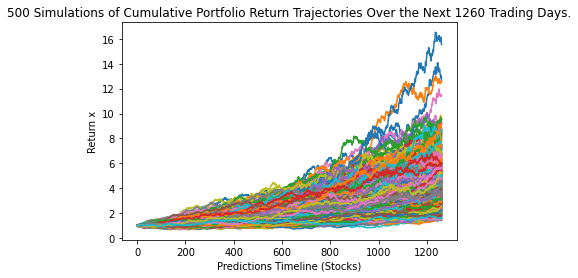

In [127]:
# Plot simulation outcomes
mc_even_distline_plot = mc_even_dist.plot_simulation()
plt.xlabel('Predictions Timeline (Stocks)')
plt.ylabel('Return x')

Text(0.5, 0, 'Return x')

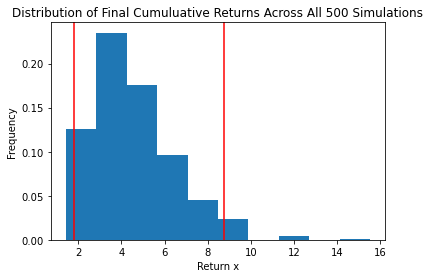

In [56]:
# Plot probability distribution and confidence intervals
mc_dist_plot = mc_even_dist.plot_distribution()
plt.xlabel('Return x')

In [57]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
mc_even_dist_2 = MCSimulation(
    portfolio_data = crypto_df, 
    weights = [0.2, 0.2, 0.2, 0.2, 0.2], 
    num_simulation = 500, 
    num_trading_days = 252*5
)

In [58]:
# Printing the simulation input data
mc_even_dist_2.portfolio_data.head()

BTC                     ETH                     LTC  \
                close daily_return      close daily_return      close   
date                                                                    
2017-05-05  1506.0438          NaN  91.160387          NaN  26.199396   
2017-05-06  1547.8150     0.027736  96.427680     0.057780  28.175799   
2017-05-07  1557.8838     0.006505  89.739679    -0.069358  30.199878   
2017-05-08  1633.3800     0.048461  87.948120    -0.019964  28.656030   
2017-05-09  1700.1775     0.040895  87.502444    -0.005067  30.062591   

                              XRP                ADA               
           daily_return     close daily_return close daily_return  
date                                                               
2017-05-05          NaN  0.092864          NaN   NaN          NaN  
2017-05-06     0.075437  0.102521     0.103991   NaN          NaN  
2017-05-07     0.071838  0.137873     0.344827   NaN          NaN  
2017-05-08    -0.051121  0.201431     0.460989   NaN          NaN  
2017-05-09     0.049084  0.160441    -0.203494   NaN          NaN

In [59]:
# Run Monte-Carlo Simulation
mc_even_dist_2.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0          1           2          3          4          5    \
0       1.000000   1.000000    1.000000   1.000000   1.000000   1.000000   
1       1.000197   1.002294    1.020353   1.007726   1.027319   0.994173   
2       1.011916   0.975175    1.026727   1.017706   1.025342   1.021976   
3       1.021135   0.988601    1.048522   1.003394   1.017149   1.043005   
4       1.001052   1.028946    1.077754   1.014882   1.016013   1.059479   
...          ...        ...         ...        ...        ...        ...   
1256  609.789514  82.139487  163.871572  20.671360  73.207513  19.375297   
1257  616.659887  81.800271  162.430456  19.981440  74.575676  18.240228   
1258  635.706030  81.575457  159.729035  20.226573  76.396146  17.781062   
1259  606.974660  82.361610  168.343071  20.838107  78.395544  17.083596   
1260  636.649884  81.703360  169.954063  22.117374  77.815498  17.026827   

           6          7          8          9    ...        490        491  \
0     1.000000   1.000000   1.000000   1.000000  ...   1.000000   1.000000   
1     0.959530   1.050050   1.037383   1.023461  ...   1.030686   1.024643   
2     0.921468   1.083320   1.010331   1.002510  ...   0.997488   1.056447   
3     0.986862   1.123870   0.980370   1.020490  ...   1.019608   0.993194   
4     0.986861   1.125811   0.957675   1.024753  ...   1.029618   1.031214   
...        ...        ...        ...        ...  ...        ...        ...   
1256  6.659174  45.952791  51.118451  75.099476  ...  73.932140  44.762439   
1257  6.731144  46.149697  51.401133  71.920580  ...  74.599829  45.493342   
1258  6.939318  48.536822  52.141561  71.738518  ...  75.849913  47.394713   
1259  7.045568  47.035718  51.176894  70.253407  ...  77.063380  45.586677   
1260  7.299751  47.667581  47.831673  69.093175  ...  76.786009  46.585985   

            492        493        494       495        496         497  \
0      1.000000   1.000000   1.000000  1.000000   1.000000    1.000000   
1      0.991487   0.985034   0.973732  1.039859   0.967170    0.975725   
2      1.019546   0.969832   0.984970  1.068513   0.971552    0.980881   
3      1.012361   0.999850   0.998456  1.083507   0.947346    1.016179   
4      0.994445   1.029590   1.011991  1.066891   0.945306    0.959084   
...         ...        ...        ...       ...        ...         ...   
1256  22.398117  22.615315  62.250899  5.497236  36.522029  741.488439   
1257  21.989572  21.581859  67.474276  5.291095  35.164824  751.539885   
1258  22.466150  21.658204  67.626777  5.367708  34.105038  702.787614   
1259  22.685755  21.811999  70.450700  5.523985  33.664651  719.502351   
1260  22.095032  21.448248  68.804497  5.630578  32.880891  713.161371   

            498        499  
0      1.000000   1.000000  
1      1.038681   1.019075  
2      1.023309   1.005719  
3      0.998384   1.001150  
4      0.988742   1.005617  
...         ...        ...  
1256  24.555558  78.817213  
1257  24.861088  77.520312  
1258  24.980676  79.342990  
1259  25.887679  76.739202  
1260  27.775074  73.838893  

[1261 rows x 500 columns]

Text(0, 0.5, 'Return x')

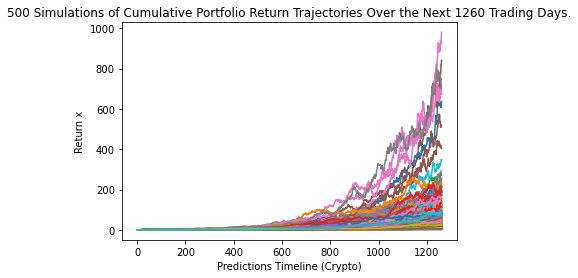

In [128]:
# Plot simulation outcomes
mc_even_distline_plot_2 = mc_even_dist_2.plot_simulation()
plt.xlabel('Predictions Timeline (Crypto)')
plt.ylabel('Return x')

Text(0.5, 0, 'Return x')

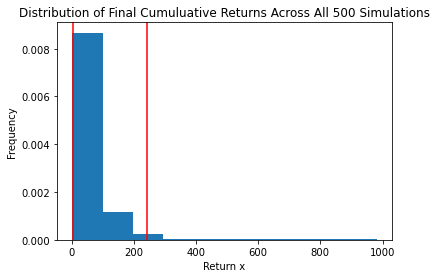

In [61]:
# Plot probability distribution and confidence intervals
mc_even_distline_plot_2 = mc_even_dist_2.plot_distribution()
plt.xlabel('Return x')

## Retirement Analysis

In [62]:
# Fetch summary statistics from the Monte Carlo simulation results
even_tbl = mc_even_dist.summarize_cumulative_return()
even_tbl_2 = mc_even_dist_2.summarize_cumulative_return()

# Print summary statistics
print(even_tbl)

count           500.000000
mean              4.526873
std               1.940288
min               1.414944
25%               3.147210
50%               4.209768
75%               5.540840
max              15.542312
95% CI Lower      1.775522
95% CI Upper      8.768190
Name: 1260, dtype: float64


In [63]:
print(even_tbl_2)

count           500.000000
mean             63.206222
std              97.218419
min               2.087441
25%              19.763763
50%              38.106914
75%              66.146631
max             980.430666
95% CI Lower      6.120631
95% CI Upper    242.630186
Name: 1260, dtype: float64


## Risk Analysis
Determine the risk of each portfolio:

1. Create a box plot for each portfolio.
2. Calculate the standard deviation for all portfolios.
3. Calculate the Annualized Standard Deviation.

Text(0, 0.5, 'Return x')

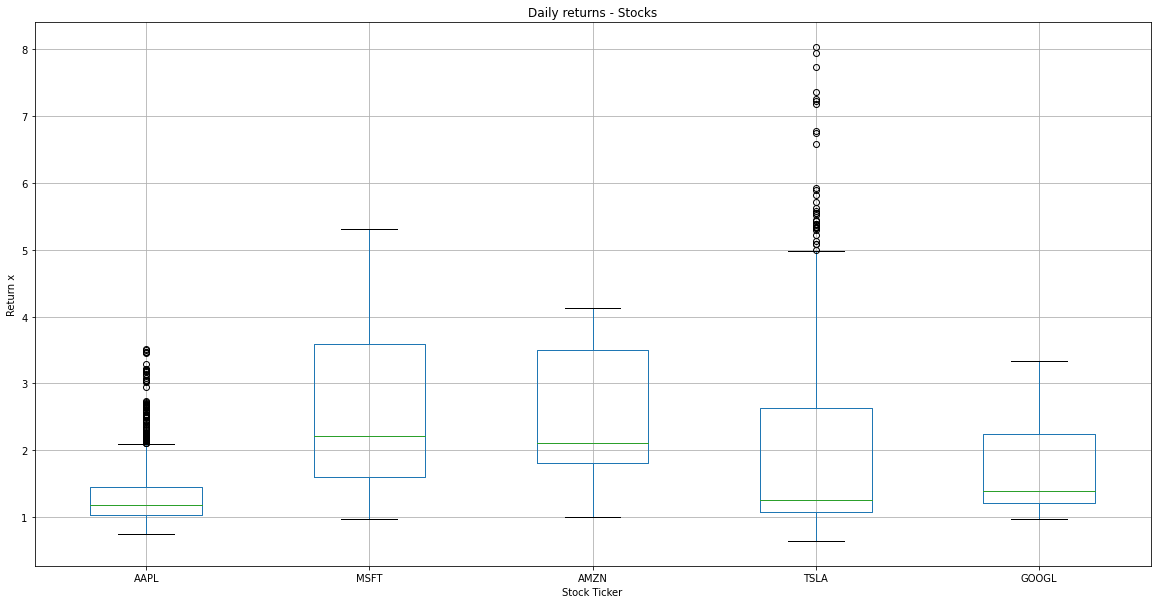

In [121]:
stock_boxplot = cumulative_returns[tickers].droplevel(axis=1, level=[-1]).boxplot(figsize=(20,10)).set_title("Daily returns - Stocks")
plt.xlabel('Stock Ticker')
plt.ylabel('Return x')

Text(0, 0.5, 'Return x')

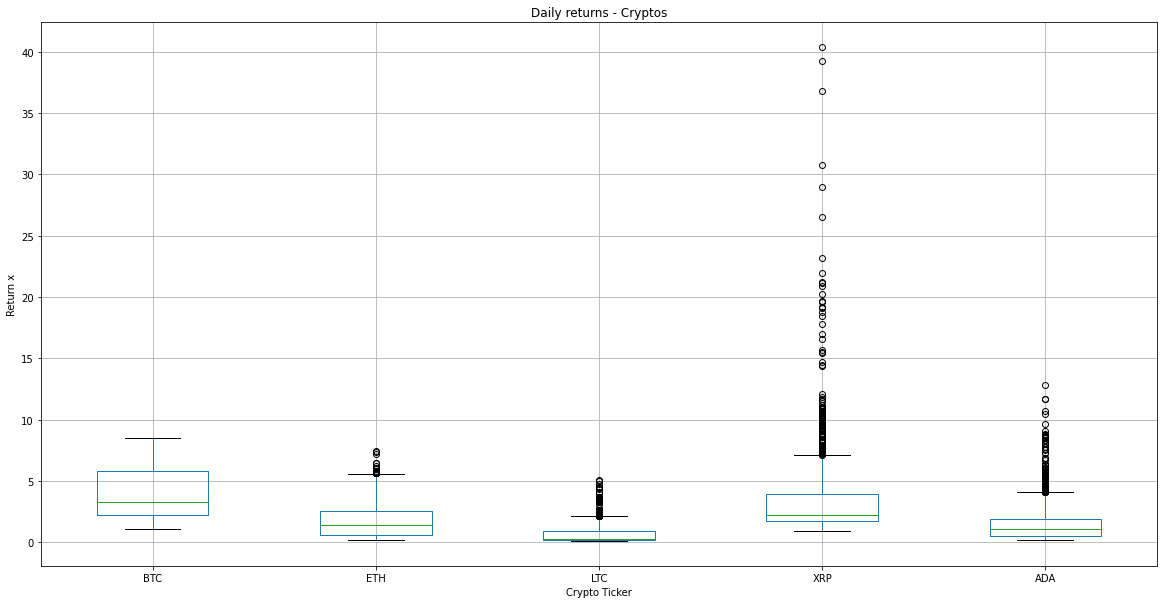

In [122]:
crypto_boxplot = cumulative_returns[crypto_tickers].droplevel(axis=1, level=[-1]).boxplot(figsize=(20,10)).set_title("Daily returns - Cryptos")
plt.xlabel('Crypto Ticker')
plt.ylabel('Return x')

## Calculate Standard Deviations

In [95]:
# Calculate the daily standard deviations of all portfolios
combined_daily_std = cumulative_returns.droplevel(axis=1, level=[-1]).std()

""" Daily Standard Deviation in decending order"""

combined_daily_std.sort_values(ascending=False)

XRP      3.665658
BTC      1.981721
ADA      1.661982
ETH      1.280264
MSFT     1.245492
TSLA     1.181228
AMZN     0.942335
LTC      0.741431
GOOGL    0.712097
AAPL     0.477175
dtype: float64

#### <font color='Red'> The Standard daviation above shows that XRP had the maximum and Apple stock had the least standard deviation over last 5 years.
</font>

In [67]:
# Calculate the annualized standard deviation (252 trading days)
annualized_std = combined_daily_std * np.sqrt(252)
annualized_std

BTC      31.458847
ETH      20.323558
LTC      11.769853
XRP      58.190520
ADA      26.383148
AAPL      7.574916
MSFT     19.771569
AMZN     14.959105
TSLA     18.751416
GOOGL    11.304184
dtype: float64

#### <font color='Red'> The Annualised Standard daviation however, shows that BTC had the maximum and Google had the least standard deviation over last 5 years.
</font>

## Rolling Statistics
Risk changes over time. Analyze the rolling statistics for Risk and Beta.

1. Calculate and plot the rolling standard deviation for all portfolios using a 21-day window.
2. Calculate the correlation between each items in the stock and crypto portfolio

## Calculate and plot rolling std for all portfolios with 30-day window

In [68]:
# Calculate the rolling standard deviation for all portfolios using a 30-day window
cumulative_returns.droplevel(axis=1, level=[-1]).rolling(window=30).std()

BTC       ETH       LTC       XRP       ADA      AAPL  \
2017-05-05       NaN       NaN       NaN       NaN       NaN       NaN   
2017-05-08       NaN       NaN       NaN       NaN       NaN       NaN   
2017-05-09       NaN       NaN       NaN       NaN       NaN       NaN   
2017-05-10       NaN       NaN       NaN       NaN       NaN       NaN   
2017-05-11       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2022-04-29  0.333667  0.182205  0.011921  0.150336  0.117009  0.043236   
2022-05-02  0.333764  0.182396  0.012066  0.155145  0.115862  0.044963   
2022-05-03  0.331714  0.180694  0.012165  0.159078  0.113775  0.046242   
2022-05-04  0.330924  0.180972  0.012293  0.161440  0.114024  0.046324   
2022-05-05  0.331338  0.180872  0.012175  0.159793  0.113886  0.048433   

                MSFT      AMZN      TSLA     GOOGL  
2017-05-05       NaN       NaN       NaN       NaN  
2017-05-08       NaN       NaN       NaN       NaN  
2017-05-09       NaN       NaN       NaN       NaN  
2017-05-10       NaN       NaN       NaN       NaN  
2017-05-11       NaN       NaN       NaN       NaN  
...              ...       ...       ...       ...  
2022-04-29  0.208703  0.233588  0.261854  0.199685  
2022-05-02  0.209835  0.264266  0.262272  0.208356  
2022-05-03  0.212026  0.289417  0.264074  0.214872  
2022-05-04  0.209904  0.305478  0.266199  0.213985  
2022-05-05  0.213481  0.333633  0.279504  0.218071  

[1258 rows x 10 columns]

In [69]:
# Plot the rolling standard deviation
rolling_window_plot = cumulative_returns.droplevel(axis=1, level=[-1]).rolling(window=30).std().hvplot.line(title='Return after 5 years With 30 Days as Weighted Average',
                                                                                                        ylabel='Return x',
                                                                                                        xlabel='Year',
                                                                                                        width=1500,
                                                                                                        height=800).opts(axiswise=True)

rolling_window_plot

:NdOverlay   [Variable]
   :Curve   [index]   (value)

#### <font color='Red'> The rolling standard deviation indicator above shows the volatility, charted for 30 days.
</font>

## Calculate and plot the correlation


In [70]:
# Calculate the correlation
correlation_df = daily_returns.droplevel(axis=1, level=[-1]).corr()
correlation_df

BTC       ETH       LTC       XRP       ADA      AAPL      MSFT  \
BTC    1.000000  0.728045  0.734533  0.475947  0.530561 -0.049026 -0.056071   
ETH    0.728045  1.000000  0.764093  0.540141  0.594198 -0.068642 -0.051059   
LTC    0.734533  0.764093  1.000000  0.539073  0.571843 -0.064046 -0.044745   
XRP    0.475947  0.540141  0.539073  1.000000  0.594079 -0.014591 -0.010973   
ADA    0.530561  0.594198  0.571843  0.594079  1.000000 -0.026982 -0.029873   
AAPL  -0.049026 -0.068642 -0.064046 -0.014591 -0.026982  1.000000  0.532587   
MSFT  -0.056071 -0.051059 -0.044745 -0.010973 -0.029873  0.532587  1.000000   
AMZN  -0.008635 -0.009658 -0.001953  0.018899  0.006608  0.418943  0.701903   
TSLA   0.009896  0.006113 -0.010235  0.005906  0.021591  0.613540  0.397233   
GOOGL -0.003715  0.002702 -0.007295  0.025607  0.001236  0.471259  0.787539   

           AMZN      TSLA     GOOGL  
BTC   -0.008635  0.009896 -0.003715  
ETH   -0.009658  0.006113  0.002702  
LTC   -0.001953 -0.010235 -0.007295  
XRP    0.018899  0.005906  0.025607  
ADA    0.006608  0.021591  0.001236  
AAPL   0.418943  0.613540  0.471259  
MSFT   0.701903  0.397233  0.787539  
AMZN   1.000000  0.326082  0.659141  
TSLA   0.326082  1.000000  0.336368  
GOOGL  0.659141  0.336368  1.000000

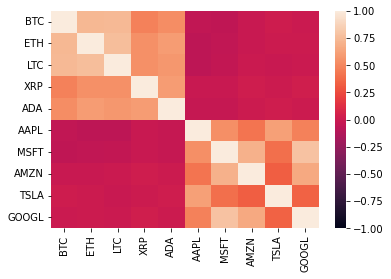

In [71]:
# Display de correlation matrix
corr_heatmap = sns.heatmap(correlation_df, vmin=-1, vmax=1)

#### <font color='Red'> The value of correlation above ranges from -1 to +1. Which clearly indicates stocks ranged in the negative territory to cryptos over last 5 years
</font>

## Sharpe Ratios
For investment perspective, daily returns might not give you a better understanding, let's at the ratio of return-to-risk, and not just returns alone.

### Using the daily returns, calculate and visualize the Sharpe ratios using a bar plot

In [72]:
sharpe_ratios = ((daily_returns.mean()-0.25) * 252) / (daily_returns.std() * np.sqrt(252))
sharpe_ratios = sharpe_ratios.droplevel(axis=0, level=[-1])
sharpe_ratios

BTC      -88.608010
ETH      -70.270541
LTC      -64.358823
XRP      -51.969314
ADA      -49.430136
AAPL    -137.357810
MSFT    -217.506110
AMZN    -194.346793
TSLA     -87.747558
GOOGL   -220.085157
dtype: float64

In [73]:
annulaised_sharpe_ratios = ((combined_daily_std.mean()-0.25) * 252) / (combined_daily_std.std() * np.sqrt(252))
annulaised_sharpe_ratios

19.683976746995047

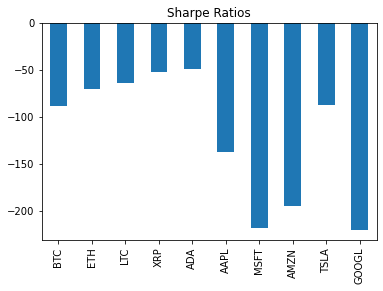

In [74]:
# Visualize the sharpe ratios as a bar plot
sharpe_ratios = sharpe_ratios.plot(kind="bar", title="Sharpe Ratios")

## Evaluate Investment Scenarios

### Scenario 1: Evaluate Investment in Original/Unoptimized Portfolio (No Modifications)

<AxesSubplot:title={'center':'Returns 50% in Crypto and 50% in Stocks'}, xlabel='Date', ylabel='Returns (USD)'>

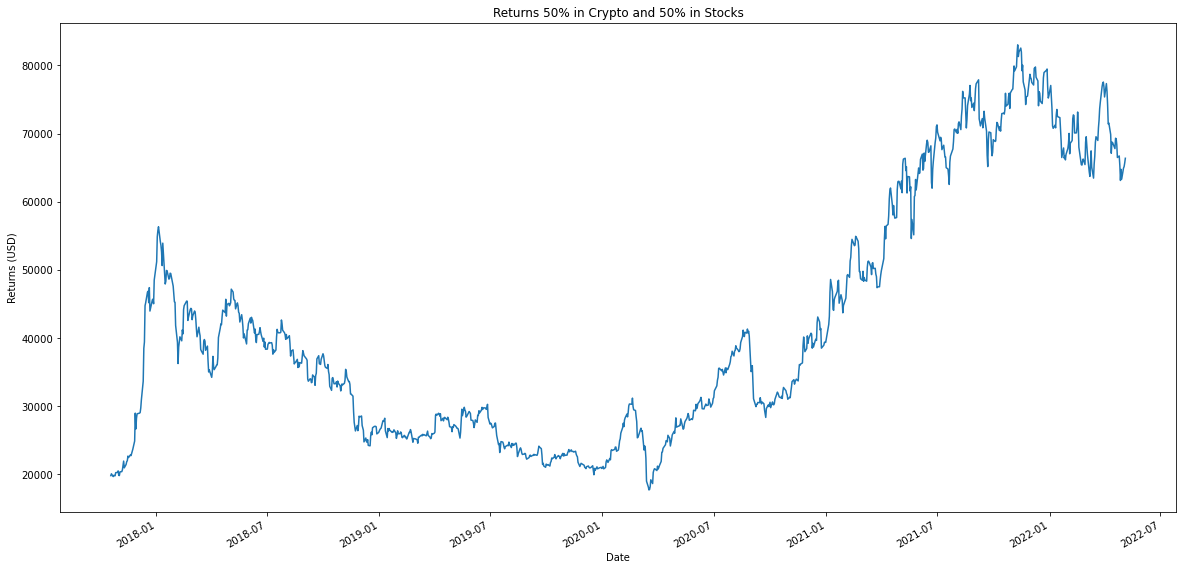

In [131]:
# Set initial investment
initial_investment = 20000

# Set weights
weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# Use the `dot` function to multiply weights by each stock's daily returns to output the unoptimized portfolio's daily returns
unoptimized_portfolio_returns = daily_returns.dot(weights)

# Use the `cumprod` function to calculate the unoptimized stock portfolio's cumulative returns
unoptimized_cumulative_returns = (1 + unoptimized_portfolio_returns).cumprod()

# Multiply the initial investment of `$20,000` against the portfolio's series of cumulative returns
unoptimized_cumulative_profits = (initial_investment * unoptimized_cumulative_returns)

# Plot the cumulatives return
unoptimized_cumulative_profits.plot(figsize=(20,10),
                                   title='Returns 50% in Crypto and 50% in Stocks',
                                   xlabel='Date',
                                   ylabel='Returns (USD)')

### Scenario 2: Evaluate Investment in Crypto optimized Portfolio (No stocks)

<AxesSubplot:title={'center':'Unoptimised Returns 100% in Crypto'}, xlabel='Date', ylabel='Returns (USD)'>

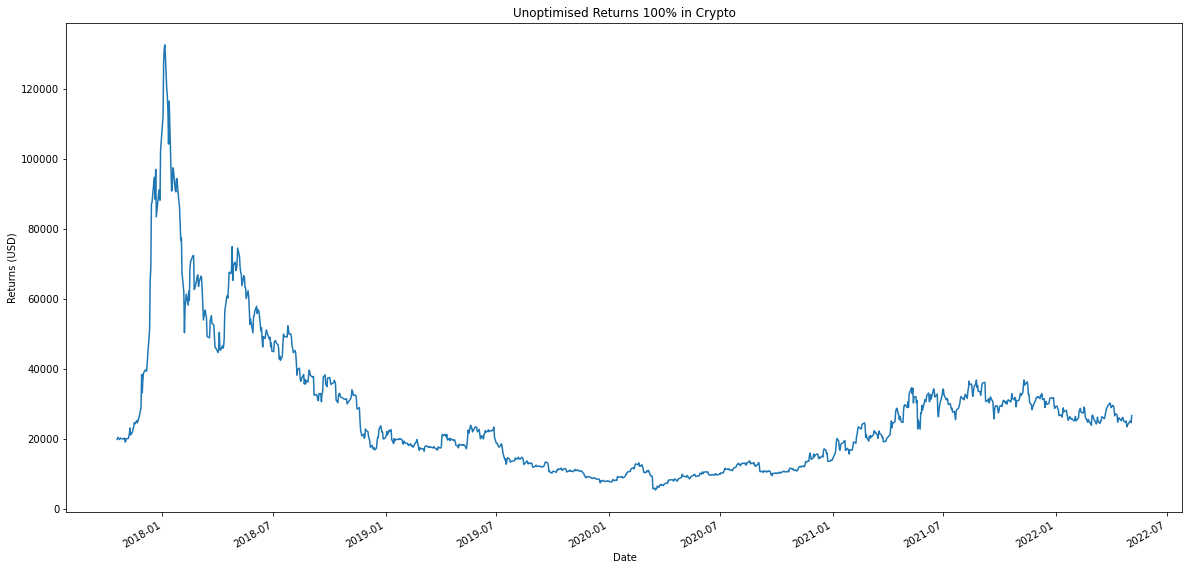

In [130]:
# Set initial investment
initial_investment = 20000

# Set weights
weights = [0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0] 

# Use the `dot` function to multiply weights by each stock's daily returns to output the unoptimized portfolio's daily returns
crypto_optimized_portfolio_returns = daily_returns.dot(weights)

# Use the `cumprod` function to calculate the unoptimized stock portfolio's cumulative returns
crypto_optimized_portfolio_returns = (1 + crypto_optimized_portfolio_returns).cumprod()

# Multiply the initial investment of `$20,000` against the portfolio's series of cumulative returns
crypto_optimized_portfolio_profits = (initial_investment * crypto_optimized_portfolio_returns)

# Plot the cumulatives return
crypto_optimized_portfolio_profits.plot(figsize=(20,10),
                                       title='Unoptimised Returns 100% in Crypto',
                                       xlabel='Date',
                                       ylabel='Returns (USD)')

### Scenario 3: Evaluate Investment in Stock optimized Portfolio (No crypto)

<AxesSubplot:title={'center':'Unoptimised Returns 100% in Stocks'}, xlabel='Date', ylabel='Returns (USD)'>

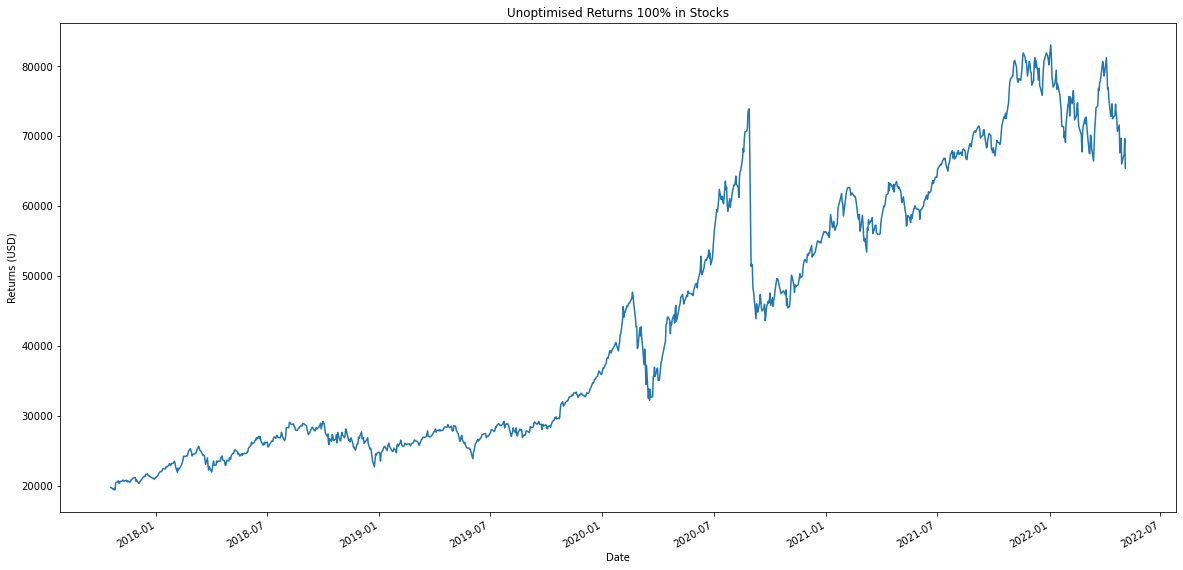

In [129]:
# Set initial investment
initial_investment = 20000

# Set weights
weights = [0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2]

# Use the `dot` function to multiply weights by each stock's daily returns to output the unoptimized portfolio's daily returns
stock_optimized_portfolio_returns = daily_returns.dot(weights)

# Use the `cumprod` function to calculate the unoptimized stock portfolio's cumulative returns
stock_optimized_portfolio_returns = (1 + stock_optimized_portfolio_returns).cumprod()

# Multiply the initial investment of `$20,000` against the portfolio's series of cumulative returns
stock_optimized_portfolio_profits = (initial_investment * stock_optimized_portfolio_returns)

# Plot the cumulatives return
stock_optimized_portfolio_profits.plot(figsize=(20,10),
                                      title='Unoptimised Returns 100% in Stocks',
                                      xlabel='Date',
                                      ylabel='Returns (USD)')

### Scenario 4: Evaluate Investment in optimized Portfolio (40% in Crpto and 60% in Stocks)

<AxesSubplot:title={'center':'Optimised Returns 40% in Crypto and 60% in Stocks'}, xlabel='Date', ylabel='Returns (USD)'>

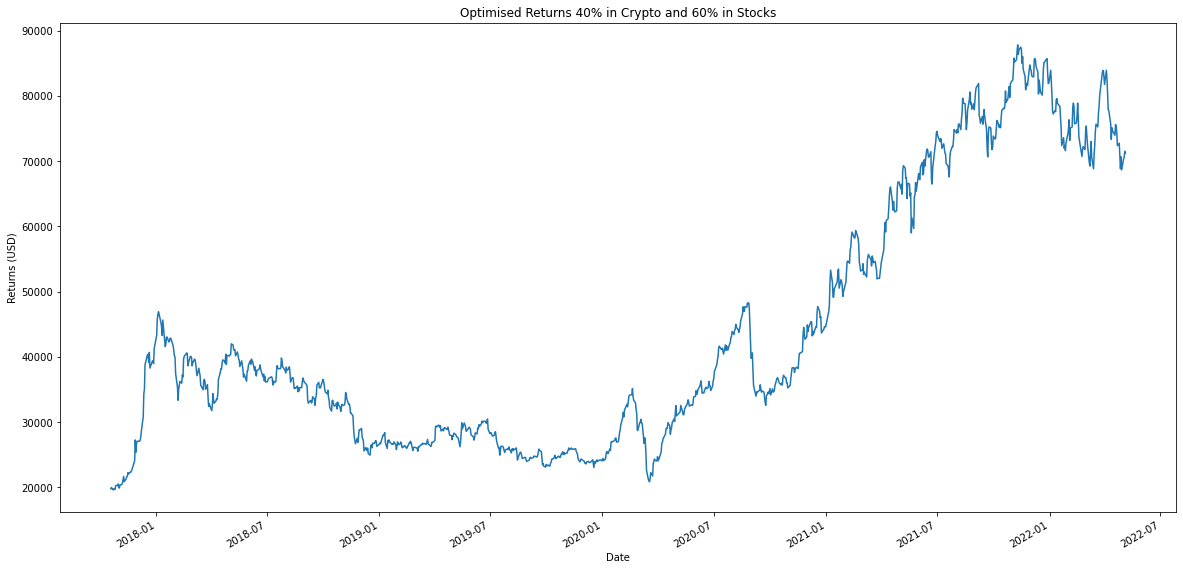

In [78]:
# Set initial investment
initial_investment = 20000

# Set weights
weights = [0.08, 0.08, 0.08, 0.08, 0.08, 0.12, 0.12, 0.12, 0.12, 0.12]

# Use the `dot` function to multiply weights by each stock's daily returns to output the unoptimized portfolio's daily returns
c40_s60_optimized_portfolio_returns = daily_returns.dot(weights)

# Use the `cumprod` function to calculate the unoptimized stock portfolio's cumulative returns
c40_s60_optimized_portfolio_returns = (1 + c40_s60_optimized_portfolio_returns).cumprod()

# Multiply the initial investment of `$20,000` against the portfolio's series of cumulative returns
c40_s60_optimized_portfolio_profits = (initial_investment * c40_s60_optimized_portfolio_returns)

# Plot the cumulatives return
c40_s60_optimized_portfolio_profits.plot(figsize=(20,10),
                                        title='Optimised Returns 40% in Crypto and 60% in Stocks',
                                        xlabel='Date',
                                        ylabel='Returns (USD)')

### Scenario 5: Evaluate Investment in optimized Portfolio (60% in Crpto and 40% in Stocks)

<AxesSubplot:title={'center':'Optimised Returns 60% in Crypto and 40% in Stocks'}, xlabel='Date', ylabel='Returns (USD)'>

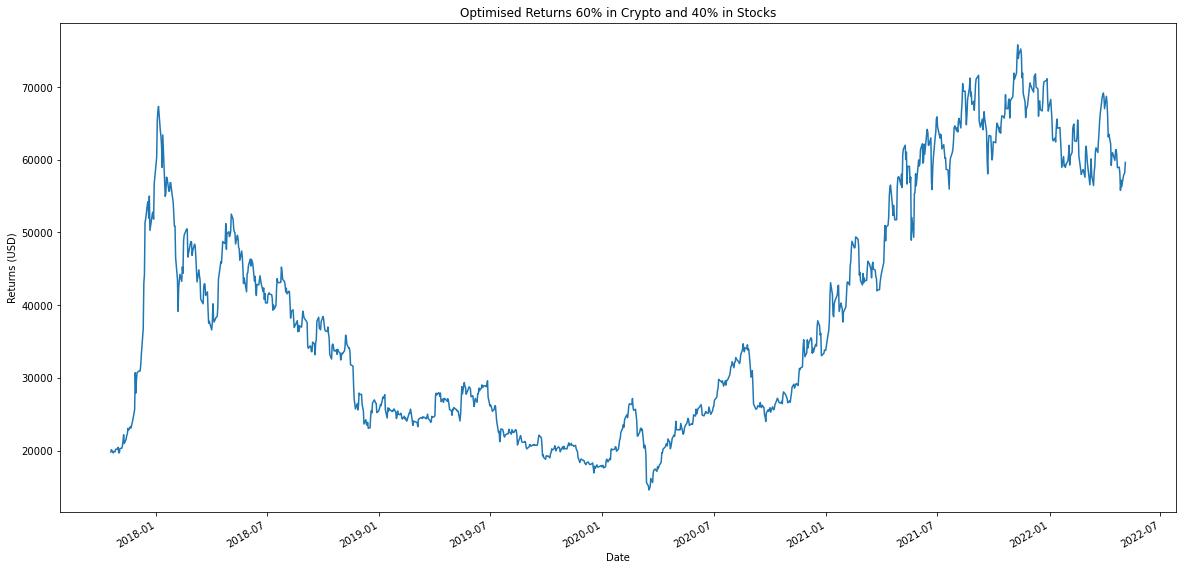

In [79]:
# Set initial investment
initial_investment = 20000

# Set weights
weights = [0.12, 0.12, 0.12, 0.12, 0.12, 0.08, 0.08, 0.08, 0.08, 0.08]

# Use the `dot` function to multiply weights by each stock's daily returns to output the unoptimized portfolio's daily returns
c60_s40_optimized_portfolio_returns = daily_returns.dot(weights)

# Use the `cumprod` function to calculate the unoptimized stock portfolio's cumulative returns
c60_s40_optimized_portfolio_returns = (1 + c60_s40_optimized_portfolio_returns).cumprod()

# Multiply the initial investment of `$20,000` against the portfolio's series of cumulative returns
c60_s40_optimized_portfolio_profits = (initial_investment * c60_s40_optimized_portfolio_returns)

# Plot the cumulatives return
c60_s40_optimized_portfolio_profits.plot(figsize=(20,10),
                                        title='Optimised Returns 60% in Crypto and 40% in Stocks',
                                        xlabel='Date',
                                        ylabel='Returns (USD)')

### Scenario Overlay - Hypothetical Portfolio Investments Scenarios

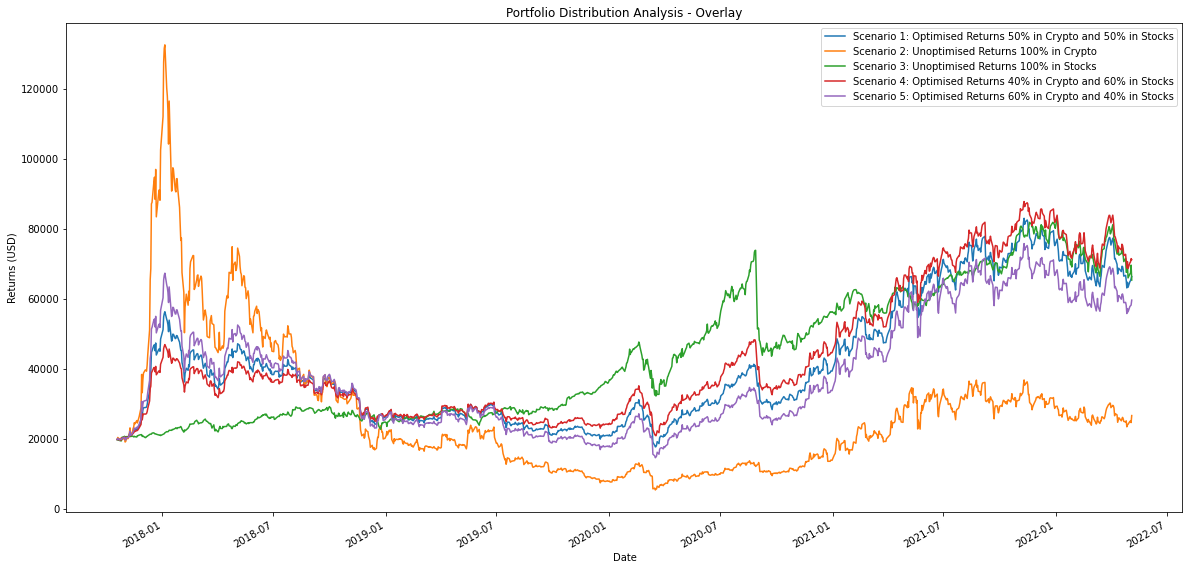

In [133]:
# Set the figure of the chart and plot each data trend on the single figure
ax = unoptimized_cumulative_profits.plot(figsize=(20,10),
                                        title='Portfolio Distribution Analysis - Overlay',
                                        xlabel='Date',
                                        ylabel='Returns (USD)')
crypto_optimized_portfolio_profits.plot(ax=ax)
stock_optimized_portfolio_profits.plot(ax=ax)
c40_s60_optimized_portfolio_profits.plot(ax=ax)
c60_s40_optimized_portfolio_profits.plot(ax=ax)

ax.legend(['Scenario 1: Optimised Returns 50% in Crypto and 50% in Stocks', 
           'Scenario 2: Unoptimised Returns 100% in Crypto', 
           'Scenario 3: Unoptimised Returns 100% in Stocks', 
           'Scenario 4: Optimised Returns 40% in Crypto and 60% in Stocks', 
           'Scenario 5: Optimised Returns 60% in Crypto and 40% in Stocks'])

#### <font color='Red'> The top performing portfolio distribution is 40% Crypto and 60% Stocks</font>

## Performance Analysis
Calculate and Plot the daily returns.


In [81]:
ewm_30days = cumulative_returns.droplevel([-1], axis=1).ewm(halflife=30).mean().hvplot.line(
    title='Return after 5 years With 30 Days as Weighted Average',
    ylabel='Return x',
    xlabel='Year',
    width=1500,
    height=800
).opts(axiswise=True)

ewm_30days

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [126]:
combined_cumulative_returns_line = daily_returns.droplevel([-1], axis=1).hvplot.line(
    title='Return after 5 years',
    ylabel='Return x',
    xlabel='Year',
    width=1500,
    height=800
).opts(axiswise=True)

combined_cumulative_returns_line

:NdOverlay   [Variable]
   :Curve   [index]   (value)

## Crypto Performance
Performance graphs for the past 5 years of crypto

In [83]:
# Define a function that creates line graphs
def create_line_chart(investment, investment_type):
    investment=investment
    investment_type=investment_type
    data=combined_investments[investment_type][investment].hvplot.line(
        title=f'Performance of {investment} over the last 5 years',
        xlabel='Year',
        ylabel='Value in USD',
        yformatter='%.0f'
        ).opts(axiswise=True)
    return data

In [84]:
# BTC graph
btc_5 = create_line_chart(
    investment_type='Crypto Data',
    investment='BTC',
)
display(btc_5)

# ETH graph
eth_5 = create_line_chart(
    investment_type='Crypto Data',
    investment='ETH',
)
display(eth_5)

# LTC graph
ltc_5 = create_line_chart(
    investment_type='Crypto Data',
    investment='LTC',
)
display(ltc_5)

# XRP graph
xrp_5 = create_line_chart(
    investment_type='Crypto Data',
    investment='XRP',
)
display(xrp_5)

# ADA graph
ada_5 = create_line_chart(
    investment_type='Crypto Data',
    investment='ADA',
)
display(ada_5)

:Curve   [index]   (close)

:Curve   [index]   (close)

:Curve   [index]   (close)

:Curve   [index]   (close)

:Curve   [index]   (close)

## Stock Performance
Performance graphs for the past 5 years of stocks

In [85]:
# AAPL graph
aapl_5 = create_line_chart(
    investment_type='Stock Data',
    investment='AAPL',
)
display(aapl_5)

# MSFT graph
msft_5 = create_line_chart(
    investment_type='Stock Data',
    investment='MSFT',
)
display(msft_5)

# AMZN graph
amzn_5 = create_line_chart(
    investment_type='Stock Data',
    investment='AMZN',
)
display(amzn_5)

# TSLA graph
tsla_5 = create_line_chart(
    investment_type='Stock Data',
    investment='TSLA',
)
display(tsla_5)

# GOOGL graph
googl_5 = create_line_chart(
    investment_type='Stock Data',
    investment='GOOGL',
)
display(googl_5)

:Curve   [index]   (close)

:Curve   [index]   (close)

:Curve   [index]   (close)

:Curve   [index]   (close)

:Curve   [index]   (close)

In [86]:
#Run the Covid plot
covid_cumulative_returns_plot = cumulative_returns.loc["2020-01-01" : "2020-04-05"].droplevel(axis=1, level=[-1]).hvplot.line(title='Volatitlity to Blackswan Event (Covid-19)',
                                                                                                                             xlabel='Date',
                                                                                                                              ylabel='Return x',
                                                                                                                              width=1500,
                                                                                                                              height=800
                                                                                                                             ).opts(axiswise=True)
covid_cumulative_returns_plot

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [87]:
# #Run the War  plot for zoomed in graph
market_uncertaintity_plot = cumulative_returns.droplevel(axis=1, level=[-1]).loc["2021-11-10" : "2022-05-05"].hvplot.line(title='Volatility to Market Uncertaintity',
                                                                                                                         ylabel='Return x',
                                                                                                                         xlabel='Date',
                                                                                                                         width=1500,
                                                                                                                         height=800
                                                                                                                         ).opts(axiswise=True)
market_uncertaintity_plot

:NdOverlay   [Variable]
   :Curve   [index]   (value)

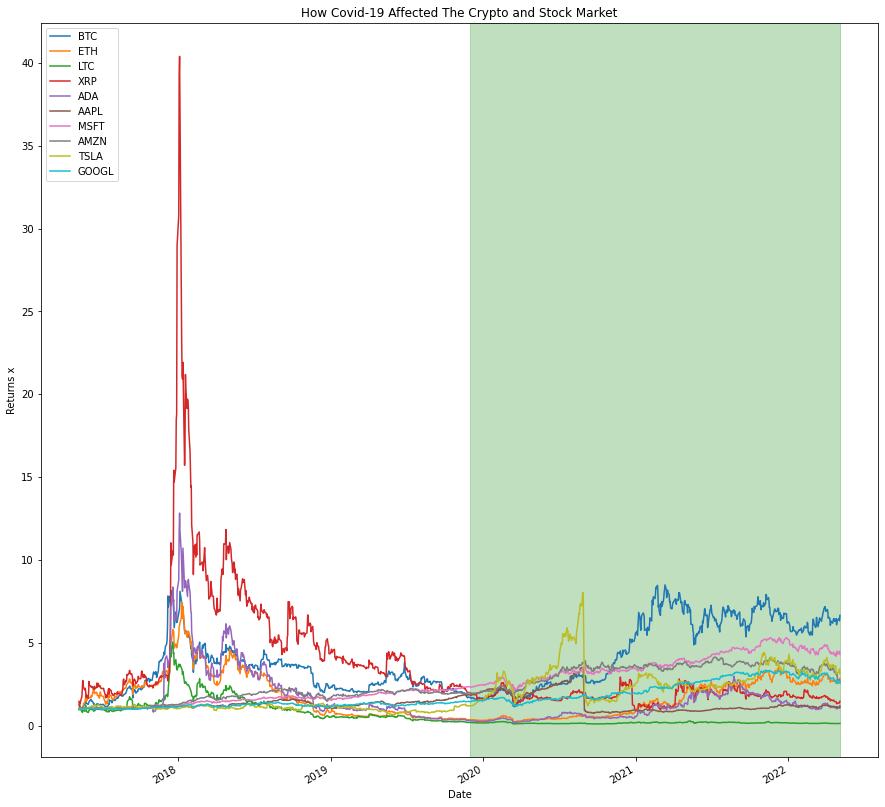

In [88]:
#Run the Covid plot
cumulative_returns.droplevel(axis=1, level=[-1]).plot(
    kind='line',
    figsize=(15,15),
    title='How Covid-19 Affected The Crypto and Stock Market',
    xlabel='Date',
    ylabel='Returns x'
)

#Highlight start to end date of interest
plt.axvspan("2019-12-01", "2022-05-05", color='green', alpha=0.25)

Text(2021-11-26, 8.1, 'Covid Omicron strain')

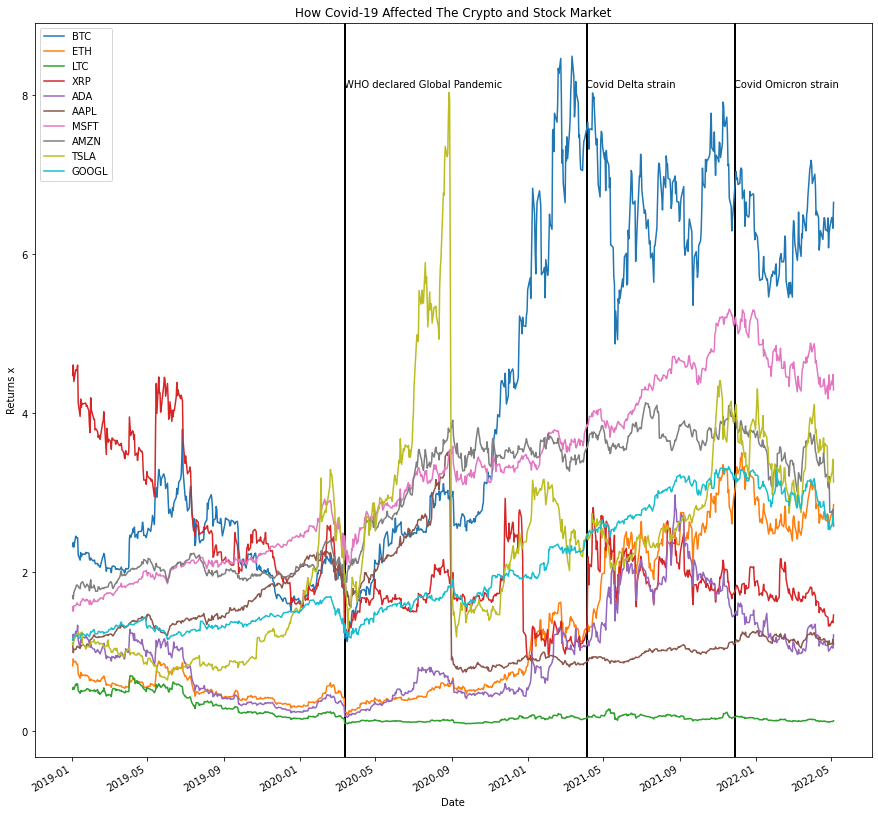

In [89]:
#Run the Covid plot for zoomed in graph
covid_cumulative_returns_plot_2 = cumulative_returns.loc["2019-01-01"  : "2022-05-05"].droplevel(axis=1, level=[-1]).plot(
    kind='line',
    figsize=(15,15),
    title='How Covid-19 Affected The Crypto and Stock Market',
    xlabel='Date',
    ylabel='Returns x'
);

#Highlight imporatnt dates of Covid
plt.axvspan("2020-03-11", "2020-03-13", color='black', alpha=1);
plt.axvspan("2021-04-04", "2021-04-05", color='black', alpha=1);
plt.axvspan("2021-11-26", "2021-11-28", color='black', alpha=1);

#Add text label
covid_cumulative_returns_plot_2.text(
"2020-03-11", 8.1, "WHO declared Global Pandemic")
covid_cumulative_returns_plot_2.text(
"2021-04-04", 8.1, "Covid Delta strain")
covid_cumulative_returns_plot_2.text(
"2021-11-26", 8.1, "Covid Omicron strain")

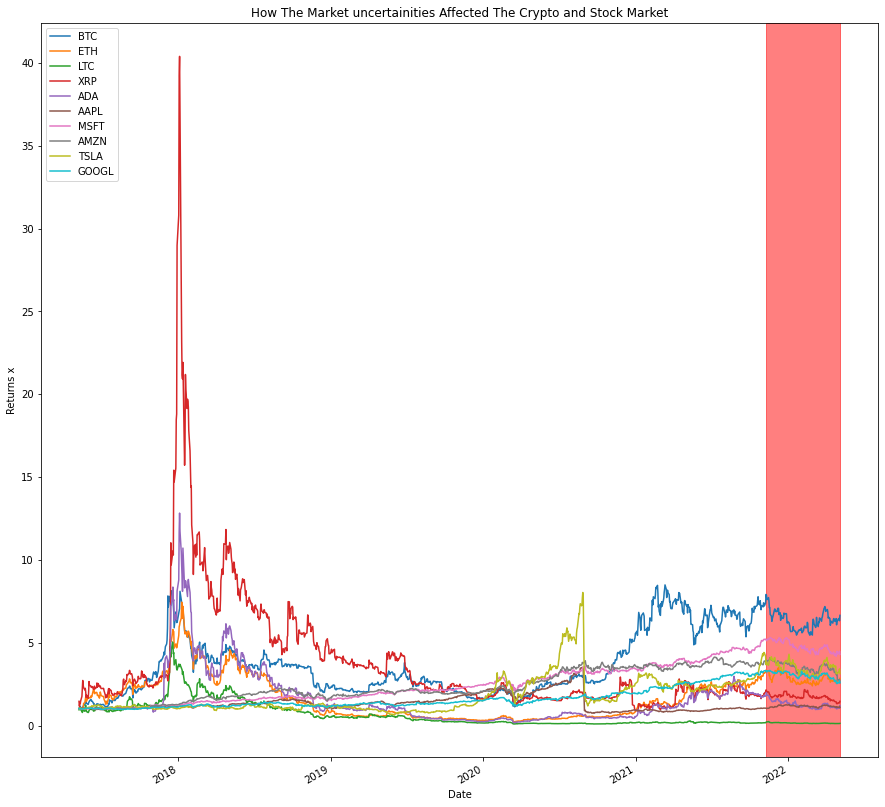

In [120]:
#Run the War plot
cumulative_returns.droplevel(axis=1, level=[-1]).plot(
    kind='line',
    figsize=(15,15),
    title='How The Market uncertainities Affected The Crypto and Stock Market',
    xlabel='Date',
    ylabel='Returns x'
)
#Highlight start to end date of interest
plt.axvspan("2021-11-10", "2022-05-05", color='red', alpha=0.5)

Text(2022-02-24, 10, 'Russia launched invasion of Ukraine')

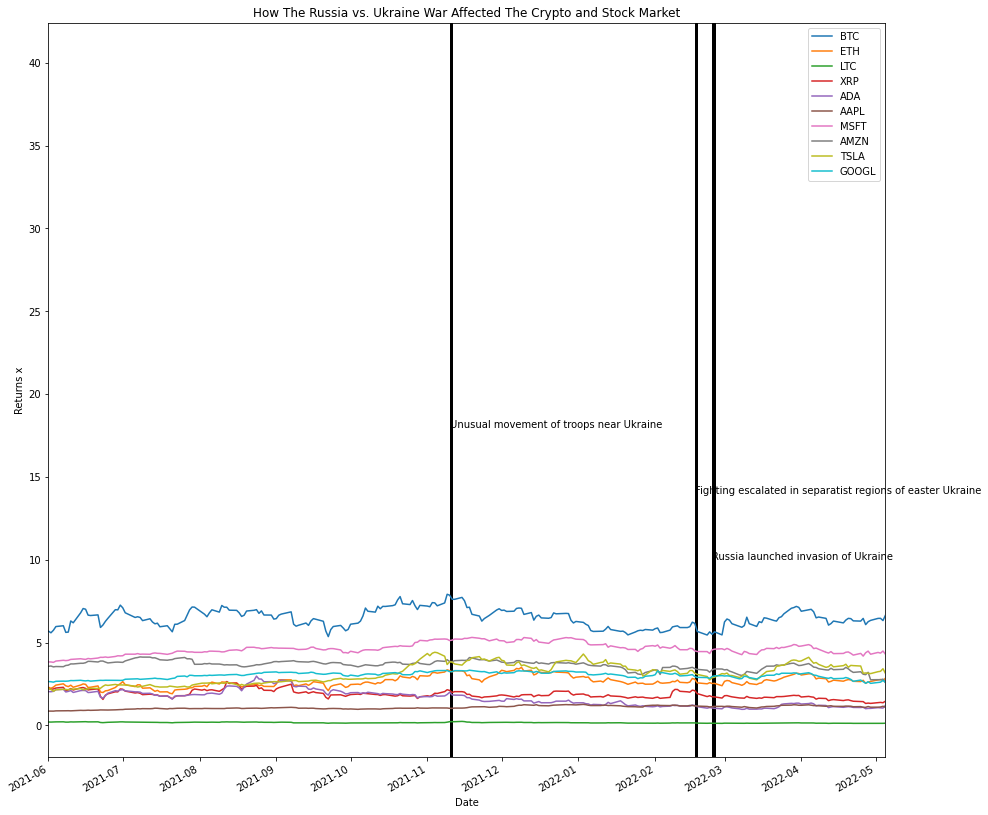

In [91]:
#Run the War  plot for zoomed in graph
market_uncertaintity_plot_2 = cumulative_returns.droplevel(axis=1, level=[-1]).plot(
    kind='line',
    figsize=(15,15),
    title='How The Russia vs. Ukraine War Affected The Crypto and Stock Market',
    xlabel='Date',
    ylabel='Returns x'
)

#Zoom in
market_uncertaintity_plot_2.set_xlim("2021-06-01", "2022-05-05")
#Highlight imporatnt dates of Covid
plt.axvspan("2021-11-10", "2021-11-11", color='black', alpha=1)
plt.axvspan("2022-02-17", "2022-02-18", color='black', alpha=1)
plt.axvspan("2022-02-24", "2022-02-25", color='black', alpha=1)
#Add text label
market_uncertaintity_plot_2.text(
"2021-11-10", 18, "Unusual movement of troops near Ukraine")
market_uncertaintity_plot_2.text(
"2022-02-17", 14, "Fighting escalated in separatist regions of easter Ukraine")
market_uncertaintity_plot_2.text(
"2022-02-24", 10, "Russia launched invasion of Ukraine")

## Dashboard

In [117]:
# Create a Title for the Dashboard
dash_title = '## Welcome to Investment Analysis - Dashboard'

# Define a welcome text
welcome_message =  '''
There's one golden investment rule that you should always keep in mind: Never invest money that you can't afford to lose. Market can be rewarding, but it do tests you.  Always Do Your Own Research - DYOR"
'''

welcome_message2 = '#### Pease click along the tabs to explore graphs'

welcome_pane = pn.Column(
    dash_title,
    welcome_message,
    welcome_message2,
)

# Create panels to structure the layout of the dashboard
# Dwelling ypes Panel
returns_anlysis = pn.Column(
    "## Analysis on Returns Over 5 Years",
    pn.Row(combined_value_after_5_years_bar),
    pn.Row(stock_value_after_5_years_bar, crypto_value_after_5_years_bar)
)

performance_analysis = pn.Column(
    '## Performance of Crypto vs. Stock',
    pn.Row(btc_5, aapl_5),
    pn.Row(eth_5, msft_5),
    pn.Row(ltc_5, amzn_5),
    pn.Row(xrp_5, tsla_5),
    pn.Row(ada_5, googl_5)
    )

ewm_rolling = pn.Column(
    ewm_30days, rolling_window_plot)

volatility = pn.Column(covid_cumulative_returns_plot, market_uncertaintity_plot)

dashboard = pn.Tabs(
    ('Welcome', welcome_pane),
    ('Performance Analysis', performance_analysis),
    ('Returns', returns_anlysis),
    ('Volatility', volatility),
    ('Cumulative Return', ewm_rolling),
)

In [118]:
dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Markdown(str)
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(Curve)
            [1] HoloViews(Curve)
        [2] Row
            [0] HoloViews(Curve)
            [1] HoloViews(Curve)
        [3] Row
            [0] HoloViews(Curve)
            [1] HoloViews(Curve)
        [4] Row
            [0] HoloViews(Curve)
            [1] HoloViews(Curve)
        [5] Row
            [0] HoloViews(Curve)
            [1] HoloViews(Curve)
    [2] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(Bars)
        [2] Row
            [0] HoloViews(Bars)
            [1] HoloViews(Bars)
    [3] Column
        [0] HoloViews(NdOverlay)
        [1] HoloViews(NdOverlay)
    [4] Column
        [0] HoloViews(NdOverlay)
        [1] HoloViews(NdOverlay)